<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/explicabilidad_de_modelos/explicaciones_aditivas_con_valor_de_shapley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Valores SHAP (explicaciones aditivas de Shapley)

**Objetivo:** Sofisticar el entendimiento y la interpretabilidad de los modelos de aprendizaje automático con un método basado en teoría de juegos cooperativos.

## Introducción

Su fundamento se basa en los valores SHAP de la teoría de juegos que fueron definidos en los años 50s por Lloyd Shapley quien fue economista y matemático, también ganó el Premio Nobel de economía en 2012.

A manera de intuición, pensemos en un juego colaborativo, el que sea, tal que genere un pago (o recompensa). Los jugadores al final del juego llegan a una cantidad específica de dinero. La pregunta que se busca responder es, ¿cómo dividimos la ganancia entre estos jugadores de manera justa, suponiendo que cada jugador contribuyó de manera diferente al juego?

**¿Cuál es una manera justa de repartir ganancias?**

Shapley definió por primera vez las propiedades de equidad como:

- Aditividad:
Significa que la suma del dinero que el total de jugadores reúne debe ser el resultado del juego.
- Consistencia:
Que si un jugador aporta más al juego no puede recibir menos dinero.

Se demostró que los valores de Shapley son solución única para distribuir este dinero. Manteniendo las propiedades de equidad, por supuesto.

**¿Qué son los valores de Shaply?**

Es la cantidad de dinero que recibiría un jugador.

**¿Cómo se calculan?**

Para calcular los valores de Shaply para un jugador en el juego se debe cuantificar la aportación marginal de este jugador, esto significa que se debe ejecutar el juego con y sin este jugador, pero en para cada subconjunto posible de jugadores.

Por lo tanto, se toma un subconjunto específico de jugadores y se calcula el resultado del juego para este subconjunto con y sin el jugador. Posteriormente se toma el promedio sobre todos los subconjuntos de jugadores y estos son los valores de Shaply.

**¿Cómo adaptan los valores de Shapley a soluciones basadas en aprendizaje automático?**

Scott Lundberg y Su-In Lee de la Universidad de Washington publicaron un primer artículo en 2017 titulado *'Un enfoque unificado para interpretar las predicciones del modelo'* y propusieron adaptar los valores de Shaply para modelos de aprendizaje automático.

### Funcionamiento

SHAP es un método local pues se explica una observación de entrada específica a la vez.

Primeramente se cuentan todos los subconjuntos posibles de variables y se calcula el resultado del modelo a lo largo del subconjunto con y sin alguna variable.
Se toma la diferencia entre esos dos resultados con y sin variable y luego se obtiene una contribución marginal específica, se promedia sobre todos los subconjuntos posibles de variables y este es el valor de Shapley para esta variable para este modelo.

Siguiendo las definiciones de los valores de Shaply, por lo tanto, es la única solución para distribuir las contribuciones de las variables y mantener las propiedades de equidad. Entonces, esta es la única solución posible para mantener la aditividad y la consistencia.


#### Conjunto de Datos

A manera de ejemplo se trabajará con un conjunto de datos de fútbol soccer.

Se intenta predecir si un equipo haría que un jugador ganara el premio al 'Jugador del Partido'.

Por ejemplo, nos podríamos preguntar:

* ¿Cuánto fue una predicción impulsada por el hecho de que el equipo anotó 3 goles?

Por supuesto, cada equipo tiene muchas características. Entonces, si se responde esta pregunta para la cantidad de goles, se podría repetir el proceso para todas las demás variables.

Los valores SHAP hacen esto de una manera que se garantiza una propiedad: los valores SHAP de todas las variables se suman para explicar por qué la predicción fue diferente del valor base de predicción.

In [ ]:
!pip install shap
!pip install -q kaggle

In [ ]:
 # Cargar archivo 'kaggle.json'
 from google.colab import files
 files.upload()

In [7]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [8]:
!kaggle datasets download -d mathan/fifa-2018-match-statistics

  0% 0.00/3.86k [00:00<?, ?B/s]
100% 3.86k/3.86k [00:00<00:00, 3.74MB/s]


In [10]:
!unzip fifa-2018-match-statistics.zip

Archive:  fifa-2018-match-statistics.zip
  inflating: FIFA 2018 Statistics.csv  


In [11]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 30

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [12]:
data = pd.read_csv('./FIFA 2018 Statistics.csv')

In [13]:
data.tail(4)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
124,14-07-2018,Belgium,England,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,Yes,4.0,3rd Place,No,0,NaN,NaN
125,14-07-2018,England,Belgium,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,No,NaN,3rd Place,No,0,NaN,NaN
126,15-07-2018,France,Croatia,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,Yes,18.0,Final,No,0,1.0,18.0
127,15-07-2018,Croatia,France,2,61,15,3,8,4,6,1,15,3,83,547,100,13,1,0,0,No,28.0,Final,No,0,NaN,NaN


In [17]:
data['Man of the Match'].value_counts(1)

Yes    0.5
No     0.5
Name: Man of the Match, dtype: float64

In [18]:
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

In [22]:
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
y = (data['Man of the Match'] == "Yes")  # Convertir cadena "Sí"/"No" a formato binario

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

In [25]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

Se analizarán los valores SHAP para una sola fila del conjunto de datos (se selecciona arbitrariamente la fila 5).

In [26]:
row_to_show = 5
data_for_prediction = X_val.iloc[row_to_show]  # Use una fila de datos aquí. Es posible usar varias filas si se desea
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [27]:
model.predict_proba(data_for_prediction_array)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.29, 0.71]])

El equipo tiene un 70% de probabilidades de que un jugador gane el premio.

---

Ahora, se obtendrán los valores SHAP para esa única predicción.

In [28]:
import shap

# Crea un objeto que pueda calcular valores Shap
explainer = shap.TreeExplainer(model)

# Calcular los valores Shap
shap_values = explainer.shap_values(data_for_prediction)

El objeto `shap_values` anterior es una lista con dos matrices. La primera matriz son los valores SHAP para un resultado negativo (no gana el premio), y la segunda matriz es la lista de valores SHAP para el resultado positivo (gana el premio). Por lo general, pensamos en las predicciones en términos de la predicción de un resultado positivo, por lo que extraeremos valores SHAP para resultados positivos (extrayendo `shap_values[1]`).

Es engorroso revisar arreglos sin procesar, pero el paquete shap tiene una buena forma de visualizar los resultados.

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Si observa detenidamente el código donde creamos los valores SHAP, notará que hacemos referencia a árboles en `shap.TreeExplainer(my_model)`. Pero la librería SHAP tiene explicaciones para cada tipo de modelo.

* `shap.DeepExplainer` funciona con modelos de aprendizaje profundo.
* `shap.KernelExplainer` funciona con todos los modelos, aunque es más lento que otros explicadores y ofrece una aproximación en lugar de valores Shap exactos.

Aquí hay un ejemplo usando `KernelExplainer` para obtener resultados similares. Los resultados no son idénticos porque `KernelExplainer` da un resultado aproximado. Pero los resultados cuentan la misma historia.

In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)

In [32]:
shap.initjs()
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Además de este buen desglose de cada predicción, la librería de SHAP ofrece excelentes visualizaciones de grupos de valores SHAP. Nos centraremos en dos de estas visualizaciones. Estas visualizaciones tienen similitudes conceptuales con la importancia de la permutación y los gráficos de dependencia parcial.

### Diagramas de resumen

La importancia de la permutación es excelente porque creó medidas numéricas simples para ver qué características eran importantes para un modelo. Esto nos ayudó a hacer comparaciones entre características fácilmente, y puede presentar los gráficos resultantes a audiencias no técnicas.

Pero no le dice cómo importa cada característica. Si una característica tiene una importancia de permutación media, eso podría significar que tiene:

- un gran efecto para algunas predicciones, pero ningún efecto en general, o
- un efecto medio para todas las predicciones.

Los gráficos de resumen de SHAP nos brindan una vista panorámica de la importancia de las características y lo que la impulsa.

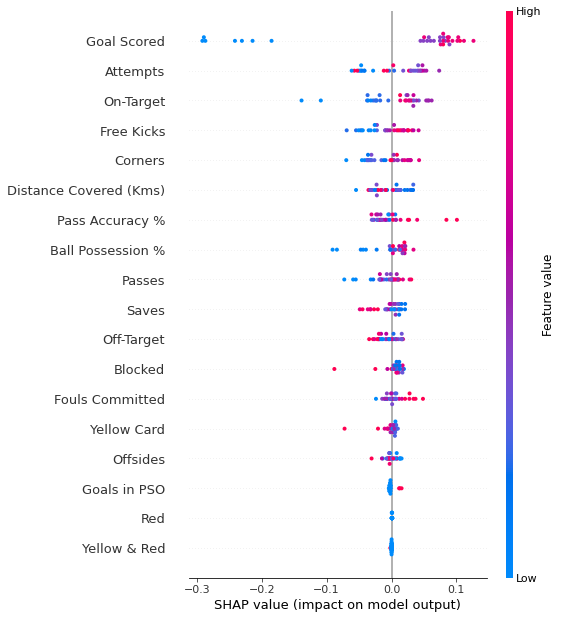

In [33]:
# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_val)

Esta trama está hecha de muchos puntos. Cada punto tiene tres características:

- La ubicación vertical muestra qué característica está representando
- El color muestra si esa característica era alta o baja para esa fila del conjunto de datos
- La ubicación horizontal muestra si el efecto de ese valor provocó una predicción más alta o más baja.

Por ejemplo, el punto en la parte superior izquierda fue para un equipo que anotó pocos goles, reduciendo la predicción en 0,25.

Algunas cosas que debería poder elegir fácilmente:

- El modelo ignoró las funciones Roja y Amarilla y Roja.
- Por lo general, la tarjeta amarilla no afecta la predicción, pero hay un caso extremo en el que un valor alto provocó una predicción mucho más baja.
- Los valores altos de Gol anotado causaron predicciones más altas, y los valores bajos causaron predicciones bajas

Si busca lo suficiente, hay mucha información en este gráfico. Te enfrentarás a algunas preguntas para probar cómo las lees en el ejercicio.

El código no es demasiado complejo. Pero hay algunas advertencias.

- Al trazar, llamamos `shap_values[1]`. Para problemas de clasificación, hay una matriz separada de valores SHAP para cada resultado posible. En este caso, indexamos para obtener los valores SHAP para la predicción de `"True"`.
- El cálculo de los valores SHAP puede ser lento. No es un problema aquí, porque este conjunto de datos es pequeño. Pero querrá tener cuidado al ejecutarlos para trazar con conjuntos de datos de tamaño razonable. La excepción es cuando se usa un modelo XGBoost, para el cual SHAP tiene algunas optimizaciones y, por lo tanto, es mucho más rápido.

Esto proporciona una excelente descripción general del modelo, pero es posible que deseemos profundizar en una sola característica. Ahí es donde entran en juego los gráficos de contribución de dependencia de SHAP.

### Gráficas de contribución de dependencia SHAP

Anteriormente, usamos diagramas de dependencia parcial para mostrar cómo una sola característica afecta las predicciones. Estos son perspicaces y relevantes para muchos casos de uso del mundo real. Además, con un poco de esfuerzo, se pueden explicar a una audiencia no técnica.

Pero hay muchas cosas que no muestran. Por ejemplo, ¿cuál es la distribución de efectos? ¿Es el efecto de tener un cierto valor bastante constante, o varía mucho dependiendo de los valores de otras características? Los gráficos de contribución de dependencia de SHAP brindan una perspectiva similar a los de PDP, pero agregan muchos más detalles.

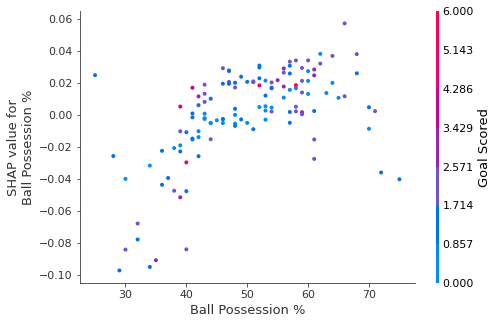

In [34]:
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

Cada punto representa un registro del conjunto de datos. La ubicación horizontal es el valor real del conjunto de datos, y la ubicación vertical muestra qué efecto tuvo ese valor en la predicción. El hecho de que tenga una pendiente ascendente indica que cuanto más poseas el balón, mayor será la predicción del modelo para ganar el premio al Jugador del partido.

El diferencial sugiere que otras funciones deben interactuar con el % de posesión del balón. 

A modo de comparación, una regresión lineal simple produciría gráficos que son líneas perfectas, sin esta dispersión.

Esto sugiere que profundicemos en las interacciones, y las gráficas incluyen códigos de colores para ayudar a hacerlo. Si bien la tendencia principal es ascendente, puede inspeccionar visualmente si varía según el color del punto.

Considere el siguiente ejemplo muy limitado para la concreción.

Si no proporciona un argumento para el índice_interacción, Shapley usa alguna lógica para elegir uno que pueda ser interesante.

Esto no requirió escribir mucho código. Pero el truco con estas técnicas está en pensar críticamente sobre los resultados en lugar de escribir el código en sí.

### Referencias

- https://arxiv.org/abs/1705.07874
- https://github.com/slundberg/shap
- http://adamlineberry.ai/shap/
- https://youtu.be/0yXtdkIL3Xk
- https://christophm.github.io/interpretable-ml-book/shapley.html
- https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

